In [1]:
import xmitgcm
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
import scipy
from matplotlib import pyplot as plt 
import cartopy as cart
import pyresample
import pandas as pd
import cmocean


from mpl_toolkits.mplot3d import Axes3D 
from scipy import interpolate
import scipy.io as sio

import warnings; warnings.simplefilter('ignore')

class LLCMapper:

    def __init__(self, ds, dx=0.25, dy=0.25):
        # Extract LLC 2D coordinates
        lons_1d = ds.XC.values.ravel()
        lats_1d = ds.YC.values.ravel()

        # Define original grid
        self.orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
        lon_tmp = np.arange(-180, 180, dx) + dx/2
        lat_tmp = np.arange(-90, -54, dy) + dy/2

        # Define the lat lon points of the two parts.
        self.new_grid_lon, self.new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
        self.new_grid  = pyresample.geometry.GridDefinition(lons=self.new_grid_lon,
                                                            lats=self.new_grid_lat)

    def __call__(self, da, ax=None, projection=cart.crs.SouthPolarStereo(), lon_0=-60, **plt_kwargs):

        assert set(da.dims) == set(['j', 'i']), "da must have dimensions ['j', 'i']"

        if ax is None:
            fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': projection})
        else:
            m = plt.axes(projection=projection)
        
        
        field = pyresample.kd_tree.resample_nearest(self.orig_grid, da.fillna(0).values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)
        field1 = pyresample.kd_tree.resample_nearest(self.orig_grid, coords.Depth.values,
                                                    self.new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)
        vmax = plt_kwargs.pop('vmax', field.max())
        vmin = plt_kwargs.pop('vmin', field.min())


        x,y = self.new_grid_lon, self.new_grid_lat

        # Find index where data is splitted for mapping
        split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


        p = ax.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=1, **plt_kwargs)
        p = ax.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                         vmax=vmax, vmin=vmin, transform=cart.crs.PlateCarree(), zorder=2, **plt_kwargs)
        p1 = ax.contour(x[:,:split_lon_idx], y[:,:split_lon_idx], field1[:,:split_lon_idx],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=1)
        p1 = ax.contour(x[:,split_lon_idx:], y[:,split_lon_idx:], field1[:,split_lon_idx:],
                         [1000], colors='black',transform=cart.crs.PlateCarree(), zorder=2)
        ax.add_feature(cart.feature.LAND, facecolor='0.5', zorder=3)
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='black',linestyle=':')
        label = ''
        if da.name is not None:
            label = da.name
        if 'units' in da.attrs:
            label += ' [%s]' % da.attrs['units']
        cb = plt.colorbar(p, shrink=0.4, label=label)
        return ax
    
    
       # coefficients nonlinear equation of state in pressure coordinates for
# 1. density of fresh water at p = 0
eosJMDCFw = [ 999.842594,
              6.793952e-02,
           -  9.095290e-03,
              1.001685e-04,
           -  1.120083e-06,
              6.536332e-09,
            ]
# 2. density of sea water at p = 0
eosJMDCSw = [     8.244930e-01,
               -  4.089900e-03,
                  7.643800e-05,
               -  8.246700e-07,
                  5.387500e-09,
               -  5.724660e-03,
                  1.022700e-04,
               -  1.654600e-06,
                  4.831400e-04,
            ]
# coefficients in pressure coordinates for
# 3. secant bulk modulus K of fresh water at p = 0
eosJMDCKFw = [    1.965933e+04,
                  1.444304e+02,
                - 1.706103e+00,
                  9.648704e-03,
                - 4.190253e-05,
             ]
# 4. secant bulk modulus K of sea water at p = 0
eosJMDCKSw = [    5.284855e+01,
                - 3.101089e-01,
                  6.283263e-03,
                - 5.084188e-05,
                  3.886640e-01,
                  9.085835e-03,
                - 4.619924e-04,
             ]
# 5. secant bulk modulus K of sea water at p
eosJMDCKP = [     3.186519e+00,
                  2.212276e-02,
                - 2.984642e-04,
                  1.956415e-06,
                  6.704388e-03,
                - 1.847318e-04,
                  2.059331e-07,
                  1.480266e-04,
                  2.102898e-04,
                - 1.202016e-05,
                  1.394680e-07,
                - 2.040237e-06,
                  6.128773e-08,
                  6.207323e-10,
            ]

def densjmd95(s,theta,p):
    """
    Computes in-situ density of sea water
    Density of Sea Water using Jackett and McDougall 1995 (JAOT 12)
    polynomial (modified UNESCO polynomial).
    Parameters
    ----------
    s : array_like
        salinity [psu (PSS-78)]
    theta : array_like
        potential temperature [degree C (IPTS-68)];
        same shape as s
    p : array_like
        pressure [dbar]; broadcastable to shape of s
    Returns
    -------
    dens : array
        density [kg/m^3]
    Example
    -------
    >>> densjmd95(35.5, 3., 3000.)
    1041.83267
    Notes
    -----
    AUTHOR:  Martin Losch 2002-08-09  (mlosch@mit.edu)
    Jackett and McDougall, 1995, JAOT 12(4), pp. 381-388
    """

    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    # convert pressure to bar
    p = .1*p
    t2 = t*t
    t3 = t2*t
    t4 = t3*t

    if np.any(s<0):
        sys.stderr.write('negative salinity values! setting to nan\n')
#       the sqrt will take care of this
#        if s.ndim > 0:
#            s[s<0] = np.nan
#        else:
#            s = np.nan
            
    s3o2 = s*np.sqrt(s)

    # density of freshwater at the surface
    rho = ( eosJMDCFw[0]
          + eosJMDCFw[1]*t
          + eosJMDCFw[2]*t2
          + eosJMDCFw[3]*t3
          + eosJMDCFw[4]*t4
          + eosJMDCFw[5]*t4*t
          )
    # density of sea water at the surface
    rho = ( rho
           + s*(
                 eosJMDCSw[0]
               + eosJMDCSw[1]*t
               + eosJMDCSw[2]*t2
               + eosJMDCSw[3]*t3
               + eosJMDCSw[4]*t4
               )
           + s3o2*(
                 eosJMDCSw[5]
               + eosJMDCSw[6]*t
               + eosJMDCSw[7]*t2
               )
           + eosJMDCSw[8]*s*s
          )

    rho = rho / (1. - p/bulkmodjmd95(s,t,p))

    return rho

def bulkmodjmd95(s,theta,p):
    """ Compute bulk modulus
    """
    # make sure arguments are floating point
    s = np.asfarray(s)
    t = np.asfarray(theta)
    p = np.asfarray(p)

    t2 = t*t
    t3 = t2*t
    t4 = t3*t

#    if np.any(s<0):
#        sys.stderr.write('negative salinity values! setting to nan\n')
#       the sqrt will take care of this
#        if s.ndim > 0:
#            s[s<0] = np.nan
#        else:
#            s = np.nan

    s3o2 = s*np.sqrt(s)

    #p = pressure(i,j,k,bi,bj)*SItoBar
    p2 = p*p
    # secant bulk modulus of fresh water at the surface
    bulkmod = ( eosJMDCKFw[0]
              + eosJMDCKFw[1]*t
              + eosJMDCKFw[2]*t2
              + eosJMDCKFw[3]*t3
              + eosJMDCKFw[4]*t4
              )
    # secant bulk modulus of sea water at the surface
    bulkmod = ( bulkmod
              + s*(      eosJMDCKSw[0]
                       + eosJMDCKSw[1]*t
                       + eosJMDCKSw[2]*t2
                       + eosJMDCKSw[3]*t3
                       )
              + s3o2*(   eosJMDCKSw[4]
                       + eosJMDCKSw[5]*t
                       + eosJMDCKSw[6]*t2
                       )
               )
    # secant bulk modulus of sea water at pressure p
    bulkmod = ( bulkmod
              + p*(   eosJMDCKP[0]
                    + eosJMDCKP[1]*t
                    + eosJMDCKP[2]*t2
                    + eosJMDCKP[3]*t3
                  )
              + p*s*(   eosJMDCKP[4]
                      + eosJMDCKP[5]*t
                      + eosJMDCKP[6]*t2
                    )
              + p*s3o2*eosJMDCKP[7]
              + p2*(   eosJMDCKP[8]
                     + eosJMDCKP[9]*t
                     + eosJMDCKP[10]*t2
                   )
              + p2*s*(  eosJMDCKP[11]
                      + eosJMDCKP[12]*t
                      + eosJMDCKP[13]*t2
                     )
               )

    return bulkmod



# aliases
dens = densjmd95 
    

In [2]:
from dask_jobqueue import SGECluster

cluster = SGECluster(cores=1,memory="6GB", interface="ib0",
             queue="Analysis3.q",
             walltime="02:00:00")
cluster.scale(10)
#62 gb total 
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SGECluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:38947,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
cluster

Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.2.1.7:38947,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [20]:
cluster.close()

In [4]:
datadir1 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/diags/'  
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4pI_cycle3/results/' 
#datadir1 = '/data2/myoungs/MITgcm_SO/experiments_mky/llc270_notides_CM4SSP_exprun/results/diags/'    
ds = xmitgcm.open_mdsdataset(datadir1,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2','fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 1200,chunks = None)
ds = ds.assign_coords(time=(ds.time+np.datetime64("1992-12-31")))
ds['drW'] = ds.hFacW * ds.drF #vertical cell size at u point
ds['drS'] = ds.hFacS * ds.drF #vertical cell size at v point
ds['drC'] = ds.hFacC * ds.drF #vertical cell size at tracer point
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('Z',): ['drW', 'drS', 'drC'], # Z distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = xgcm.Grid(ds,periodic=False,metrics=metrics)#,coords={'1RHO':{'center':'l1_c','inner':'l1_i','outer':'l1_b'}})
grid
coords = ds.coords.to_dataset().reset_coords()
#ds = ds.reset_coords(drop=True)
mapper = LLCMapper(coords)
#mapper

datadir1 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP/results/diags/' 
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP/results/' 
#datadir1 = '/data2/myoungs/MITgcm_SO/experiments_mky/llc270_notides_CM4SSP_exprun/results/diags/'    
dsp = xmitgcm.open_mdsdataset(datadir1,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2','fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 1200)
dsp = dsp.assign_coords(time=(dsp.time+np.datetime64("1992-12-31")))
gridp = xgcm.Grid(dsp, periodic=False)
#coordsp = dsp.coords.to_dataset().reset_coords()
#dsp = dsp.reset_coords(drop=True)
#mapperp = LLCMapper(coordsp)


#datadir1 = '/data3/astewart/MITgcm_SO/experiments_mky/llc270_notides_CM4pI_fixedmelt/results/diags/'     
datadir1 = '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP_fixstrat/results/diags/' 
griddir =  '/data2/antarctic_model/MITgcm_SO/experiments_mky/llc270_icb_CM4SSP_fixstrat/results/'  
dsfix = xmitgcm.open_mdsdataset(datadir1,grid_dir=griddir,prefix=['state_2d_set1','layers_3d_set2','fluxes_3d_set1','trsp_3d_set1','state_3d_set1']
                             ,geometry='curvilinear',delta_t = 900)
dsfix = dsfix.assign_coords(time=(dsfix.time+np.datetime64("1992-12-31")))

dsfix

<xarray.Dataset>
Dimensions:   (i: 1080, i_g: 1080, j: 310, j_g: 310, k: 113, k_u: 113,
               k_l: 113, k_p1: 114, time: 227, _UNKNOWN_: 123)
Coordinates: (12/49)
  * i         (i) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 ... 1073 1074 1075 1076 1077 1078 1079
  * j         (j) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 ... 302 303 304 305 306 307 308 309
  * k         (k) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
  * k_u       (k_u) int64 0 1 2 3 4 5 6 7 8 ... 105 106 107 108 109 110 111 112
    ...        ...
    rSurfC    (j, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfS    (j_g, i) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rSurfW    (j, i_g) >f4 dask.array<chunksize=(310, 1080), meta=np.ndarray>
    rhoRef    (k) >f4 dask.array<chunksize=(113,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2011-11-26
Dimensions without coordinates: _UNKNOWN_
Data variables: (12/70)
    ETAN      (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIarea    (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIheff    (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIhsnow   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SItices   (time, j, i) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    SIuice    (time, j, i_g) float32 dask.array<chunksize=(1, 310, 1080), meta=np.ndarray>
    ...        ...
    WVELSLT   (time, k_l, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    UV_VEL_Z  (time, k, j_g, i_g) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    UVELSQ    (time, k, j, i_g) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    VVELSQ    (time, k, j_g, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    gT_Forc   (time, k, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
    gS_Forc   (time, k, j, i) float32 dask.array<chunksize=(1, 113, 310, 1080), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/data2/antarc...

In [5]:
def PlotSectionLat(axes, dset, crds, latmin, latmax, lon, field):
    target_i = np.argmin(np.abs(crds.XC[300].values - lon))
    target_jmax = np.argmin(np.abs(crds.YC[:,target_i].values - latmax))
    target_jmin = np.argmin(np.abs(crds.YC[:,target_i].values - latmin))
    #print(target_i)
    #print(target_jmax)
    #print(target_jmin)
    
    y_var = dset.YC[target_jmin:target_jmax,target_i]
    bathy_0 = -1*dset.Depth[target_jmin:target_jmax,target_i]
    datheta = dset.THETA[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time').values
    dasalt = dset.SALT[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time')
    dasalt = dasalt.where(dasalt != 0).values
    p_ref = (-1029*9.81*crds.Z[69]/1e4).load()
    dens = xr.apply_ufunc(densjmd95,dasalt,datheta,p_ref,dask='allowed',output_core_dims=[('k','j')])
    
    
    CS = axes.contour(crds.YC[target_jmin:target_jmax,target_i],crds.Z,dens-1000,
                [31.6,31.8,32,32.2,32.4,32.5],colors='grey')
    if field == 'THETA':
        #vmin = datheta.min()
        #vmax = datheta.max()
        cmax = 2.1#max(np.abs(vmin),np.abs(vmax))
        #plt.title('Theta')
        

        pcm = axes.pcolormesh(crds.YC[target_jmin:target_jmax,target_i],crds.Z,
                       datheta,cmap='seismic',vmin=-cmax,vmax=cmax)

   
    if field == 'SALT':
        c_map = cmocean.cm.haline
        smin = 32.6
        smax = 34.7
        pcm = axes.pcolormesh(crds.YC[target_jmin:target_jmax,target_i],crds.Z,
                       dasalt,cmap=c_map,vmin=smin,vmax=smax)
        #plt.title('Salinity')
        
  
        
    axes.fill_between(y_var, -4000, bathy_0, color='lightgrey')
    axes.clabel(CS, CS.levels, inline=True, fontsize=10)
    axes.set_ylim([-800,0])
    axes.set_xlabel('Latitude')
    axes.set_ylabel('Depth (m)')
    #plt.colorbar()
    #plt.show()
    return pcm
    
def PlotSectionLatDiff(axes,dset1, dset2, crds, latmin, latmax, lon, field):
    target_i = np.argmin(np.abs(crds.XC[300].values - lon))
    target_jmax = np.argmin(np.abs(crds.YC[:,target_i].values - latmax))
    target_jmin = np.argmin(np.abs(crds.YC[:,target_i].values - latmin))
    #print(target_i)
    #print(target_jmax)
    #print(target_jmin)
    y_var = dset1.YC[target_jmin:target_jmax,target_i]
    bathy_0 = -1*dset1.Depth[target_jmin:target_jmax,target_i]
    datheta1 = dset1.THETA[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time').values
    dasalt1 = dset1.SALT[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time')
    dasalt1 = dasalt1.where(dasalt1 != 0).values
    
    datheta2 = dset2.THETA[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time').values
    dasalt2 = dset2.SALT[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time')
    dasalt2 = dasalt2.where(dasalt2 != 0).values
    p_ref = (-1029*9.81*crds.Z[69]/1e4).load()
    dens = xr.apply_ufunc(densjmd95,dasalt2,datheta2,p_ref,dask='allowed',output_core_dims=[('k','j')])
    
    #fig, ax = plt.subplots()
    CS = axes.contour(crds.YC[target_jmin:target_jmax,target_i],crds.Z,dens-1000,
                [31.6,31.8,32,32.2, 32.4,32.5],colors='grey')


    if field == 'THETADIFF':
        #vmin = datheta.min()
        #vmax = datheta.max()
        cmax = 2.2#max(np.abs(vmin),np.abs(vmax))
        #plt.title('Theta Diff')
        
        
        pcm = axes.pcolormesh(crds.YC[target_jmin:target_jmax,target_i],crds.Z,
                       datheta1-datheta2,cmap='seismic',vmin=-cmax,vmax=cmax)
        

        
    if field == 'SALTDIFF':
        smin = -0.7
        smax = 0.7
        pcm = axes.pcolormesh(crds.YC[target_jmin:target_jmax,target_i],crds.Z,
                       dasalt1-dasalt2,cmap='seismic',vmin=smin,vmax=smax)
        #plt.title('Salinity Diff')
        
    axes.fill_between(y_var, -4000, bathy_0, color='lightgrey')
    axes.clabel(CS, CS.levels, inline=True, fontsize=10)
    axes.set_ylim([-800,0])
    axes.set_xlabel('Latitude')
    axes.set_ylabel('Depth (m)')
    #plt.colorbar()
    #plt.show()
    return pcm
def PlotTS(axes, dset, crds, latmin, latmax, lon,color):
    target_i = np.argmin(np.abs(crds.XC[300].values - lon))
    target_jmax = np.argmin(np.abs(crds.YC[:,target_i].values - latmax))
    target_jmin = np.argmin(np.abs(crds.YC[:,target_i].values - latmin))
    #print(target_i)
    #print(target_jmax)
    #print(target_jmin)
    
    t_min = -2
    t_max = 3.1
    s_min = 32.8
    s_max = 35

# Calculate how many gridcells we need in the x and y dimensions
    xdim = int(np.ceil(s_max - s_min)/0.1)
    ydim = int(np.ceil(t_max-t_min))
    den = np.zeros((int(ydim),int(xdim)))

# Create temp and salt vectors of appropiate dimensions
    ti = np.linspace(0,ydim,ydim)+t_min
    si = np.linspace(1,xdim,xdim)*0.1+s_min
    
# Loop to fill in grid with densities
    p_ref = (-1029*9.81*crds.Z[69]/1e4).load()
    for j in range(0,int(ydim)):
        for i in range(0, int(xdim)):
            den[j,i]=densjmd95(si[i],ti[j],p_ref)

# Subtract 1000 to convert to sigma-t
    den = den - 1000
    


    zexpand = crds.Z.expand_dims(dim={"i": 1080,'j':310}).transpose('k','j','i')
    datheta = dset.THETA[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time').values
    dasalt = dset.SALT[-60:,:,target_jmin:target_jmax,target_i].mean(dim='time')
    dasalt = dasalt.where(dasalt != 0).values
    dadepth = zexpand[:,target_jmin:target_jmax,target_i].values
    #print(dadepth)
    
    dens = xr.apply_ufunc(densjmd95,dasalt,datheta,p_ref,dask='allowed',output_core_dims=[('k','j')])
    
    pcm = axes.scatter(dasalt,datheta,s=2,c=color)
    
    CS = axes.contour(si,ti,den, linestyles='dashed', colors='k')
    axes.clabel(CS, fontsize=12
           , inline=1
           , fmt='%.2f'
          ) # Label every second level
    axes.set_xlim([s_min, s_max])
    axes.grid()
    axes.set_ylim([t_min, t_max])
    axes.set_xlabel('Salinity (g/kg)')
    
    return(pcm)
    #CS = axes.contour(crds.YC[target_jmin:target_jmax,target_i],crds.Z,dens,
    #            [1031.6,1031.8,1032,1032.2, 1032.4,1032.5],colors='black')


In [ ]:


fig5 = plt.figure(figsize=(9,2.7),layout='constrained')
ax1 = plt.subplot(131)
ax2 = plt.subplot(132,projection=cart.crs.SouthPolarStereo())
ax3 = plt.subplot(133)

lon_target = -40
lat_max = -73
lat_min = -76


lats = np.arange(lat_min,lat_max,0.5)
xlin1, ylin1 = np.meshgrid(lon_target,lats)

pcm1 = PlotTS(ax1,ds,coords,lat_min,lat_max,lon_target,'royalblue')
PlotTS(ax1,dsp,coords,lat_min,lat_max,lon_target,'magenta')
PlotTS(ax1,dsfix,coords,lat_min,lat_max,lon_target,'mediumpurple')
ax1.set_ylabel('Theta ($^\circ$C)')

lon_target = 150
lat_max = -65
lat_min = -69

lats = np.arange(lat_min,lat_max,0.5)
xlin2, ylin2 = np.meshgrid(lon_target,lats)
pcm3 = PlotTS(ax3,ds,coords,lat_min,lat_max,lon_target,'royalblue')
PlotTS(ax3,dsp,coords,lat_min,lat_max,lon_target,'magenta')
PlotTS(ax3,dsfix,coords,lat_min,lat_max,lon_target,'mediumpurple')
#fig.colorbar(pcm3,ax=ax3,label='Depth (m)')

# Limit the map to -60 degrees latitude and below:
dx=0.25
dy=0.25
lon_0=-60
lons_1d = ds.XC.values.ravel()
lats_1d = ds.YC.values.ravel()
cmap = cmocean.cm.gray

        # Define original grid
orig_grid = pyresample.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

        # Longitudes latitudes to which we will we interpolate
lon_tmp = np.arange(-180, 180, dx) + dx/2
lat_tmp = np.arange(-90, -54, dy) + dy/2

        # Define the lat lon points of the two parts.
new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
new_grid  = pyresample.geometry.GridDefinition(lons=new_grid_lon,
                                                            lats=new_grid_lat)

        
field = pyresample.kd_tree.resample_nearest(orig_grid, (-1*ds.Depth).fillna(0).values,
                                                    new_grid,
                                                    radius_of_influence=100000,
                                                    fill_value=None)
       


x,y = new_grid_lon, new_grid_lat

        # Find index where data is splitted for mapping
split_lon_idx = round(x.shape[1]/(360/(lon_0 if lon_0>0 else lon_0+360)))


p = ax2.pcolormesh(x[:,:split_lon_idx], y[:,:split_lon_idx], field[:,:split_lon_idx],
                          transform=cart.crs.PlateCarree(), zorder=1,cmap=cmap)
p = ax2.pcolormesh(x[:,split_lon_idx:], y[:,split_lon_idx:], field[:,split_lon_idx:],
                          transform=cart.crs.PlateCarree(), zorder=2,cmap=cmap)
ax2.add_feature(cart.feature.LAND, facecolor='0.3', zorder=3)
ax2.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False,color='black',linestyle=':')
ax2.plot(np.squeeze(xlin1),np.squeeze(ylin1), transform=cart.crs.PlateCarree(),linewidth=4,color='r' )
ax2.plot(np.squeeze(xlin2),np.squeeze(ylin2), transform=cart.crs.PlateCarree(),linewidth=4,color='orange' )


ax1.text(32.8,2.85,'(g)')
#ax2.text(,-50,'(k)')
ax3.text(32.8,2.85,'(i)')

ax1.spines['bottom'].set_color('red')
ax1.spines['top'].set_color('red')
ax1.spines['left'].set_color('red')
ax1.spines['right'].set_color('red')


ax3.spines['bottom'].set_color('orange')
ax3.spines['top'].set_color('orange')
ax3.spines['left'].set_color('orange')
ax3.spines['right'].set_color('orange')



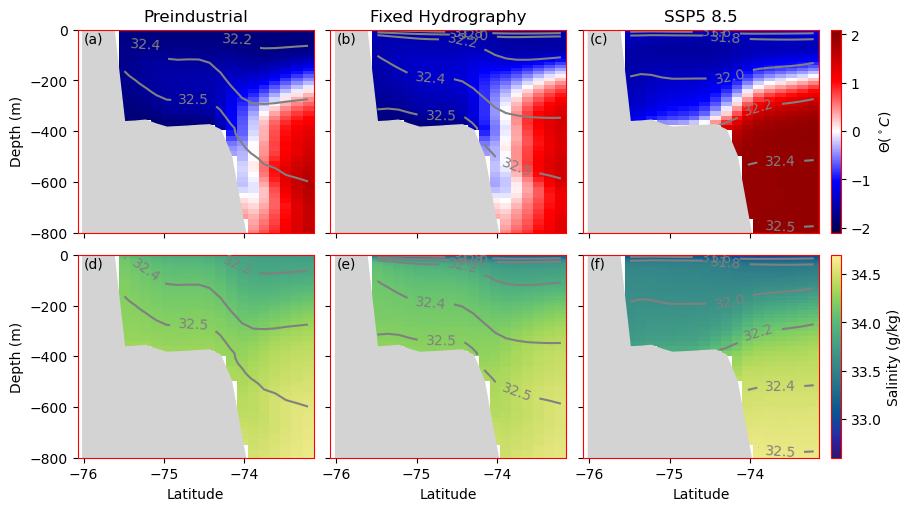

In [6]:
# plot Weddell
lon_target = -40
lat_max = -73
lat_min = -76

plt.rcParams['figure.figsize'] = [9, 5]
#plt.rcParams.update({
#    "font.family": 'Arial'
#})

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,sharex=True,sharey=True,layout='constrained')
#fig.suptitle('Weddell Sea 40 W')

pcm1 = PlotSectionLat(ax1,ds,coords,lat_min,lat_max,lon_target,'THETA')
PlotSectionLat(ax2,dsfix,coords,lat_min,lat_max,lon_target,'THETA')
pcm3 = PlotSectionLat(ax3,dsp,coords,lat_min,lat_max,lon_target,'THETA')
#fig.colorbar(pcm1, ax=ax1,label = '$\Theta (^\circ C$)')
fig.colorbar(pcm3, ax=ax3,label='$\Theta (^\circ C$)')
ax1.text(-76,-50,'(a)')
ax2.text(-76,-50,'(b)')
ax3.text(-76,-50,'(c)')

ax1.set_title('Preindustrial')
ax2.set_title('Fixed Hydrography')
ax3.set_title('SSP5 8.5')

pcm4 =PlotSectionLat(ax4,ds,coords,lat_min,lat_max,lon_target,'SALT')
PlotSectionLat(ax5,dsfix,coords,lat_min,lat_max,lon_target,'SALT')
pcm6 = PlotSectionLat(ax6,dsp,coords,lat_min,lat_max,lon_target,'SALT')
#fig.colorbar(pcm4,ax=ax4,label='Salinity (g/kg)')
fig.colorbar(pcm6,ax=ax6,label='Salinity (g/kg)')

ax4.text(-76,-50,'(d)')
ax5.text(-76,-50,'(e)')
ax6.text(-76,-50,'(f)')

for ax in fig.get_axes():
    ax.label_outer()
    
    
for ax in fig.get_axes():
    #ax.tick_params(color='green', labelcolor='green')
    for spine in ax.spines.values():
        spine.set_edgecolor('red')
        
            

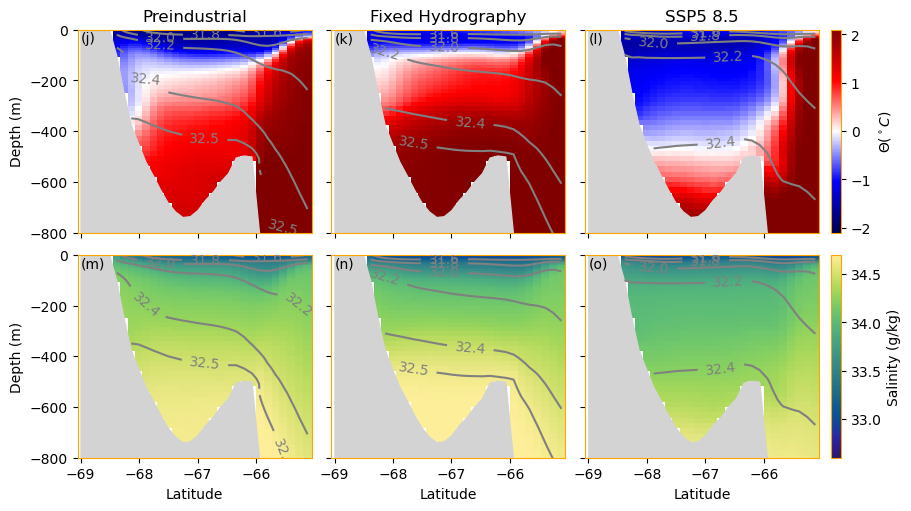

In [7]:
# East Antarctica
lon_target = 150
lat_max = -65
lat_min = -69



fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3,sharex=True,sharey=True,layout='constrained')
#fig.suptitle('East Antarctica 150 E')

pcm1 = PlotSectionLat(ax1,ds,coords,lat_min,lat_max,lon_target,'THETA')
PlotSectionLat(ax2,dsfix,coords,lat_min,lat_max,lon_target,'THETA')
pcm3 = PlotSectionLat(ax3,dsp,coords,lat_min,lat_max,lon_target,'THETA')
#fig.colorbar(pcm1, ax=ax1,label = '$\Theta (^\circ C$)')
fig.colorbar(pcm3, ax=ax3,label='$ \Theta (^\circ C$)')
ax1.text(-69,-50,'(j)')
ax2.text(-69,-50,'(k)')
ax3.text(-69,-50,'(l)')

ax1.set_title('Preindustrial')
ax2.set_title('Fixed Hydrography')
ax3.set_title('SSP5 8.5')

pcm4 =PlotSectionLat(ax4,ds,coords,lat_min,lat_max,lon_target,'SALT')
PlotSectionLat(ax5,dsfix,coords,lat_min,lat_max,lon_target,'SALT')
pcm6 = PlotSectionLat(ax6,dsp,coords,lat_min,lat_max,lon_target,'SALT')
#fig.colorbar(pcm4,ax=ax4,label='Salinity (g/kg)')
fig.colorbar(pcm6,ax=ax6,label='Salinity (g/kg)')

ax4.text(-69,-50,'(m)')
ax5.text(-69,-50,'(n)')
ax6.text(-69,-50,'(o)')

for ax in fig.get_axes():
    ax.label_outer()
    
for ax in fig.get_axes():
    #ax.tick_params(color='green', labelcolor='green')
    for spine in ax.spines.values():
        spine.set_edgecolor('orange')
        
        